In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
df = pd.read_csv('00-dbwithout_outliers.csv')
for line in df['equator_dist']:
    line = abs(line)
    df['equator_dist_abs'] = line

X = df[['over65_percent', 'HDI','life_expectancy','urban_percentage', 'mean_school', 'GDP_per_capita','pesticide','cig_prevalence', 'equator_dist_abs','fat', 'meat', 'protein', 'milk', 'calories']]
y1 = df[['cancer_percent']]
y2 = df[['incidence']]

In [33]:
# split data into train/test
msk = np.random.rand(len(df)) < 0.8

# Full set : only full set because the model is selecting the features on his own
xtrain = X[msk]
xtest = X[~msk]
y1train = y1[msk]
y1test = y1[~msk]
y2train = y2[msk]
y2test = y2[~msk]

y1= np.ravel(y1)
df_poly = X

In [34]:
df.head()

,Entity,Code,Year,cancer_percent,incidence,over65_percent,HDI,life_expectancy,population,urban_percentage,...,cig_prevalence,cig_per_smoker,vegetable,fat,meat,protein,milk,fruit,calories,equator_dist_abs
0,Albania,ALB,1990,0.771157,186.308731,5.494978,0.644,71.836,3286000,36.428,...,21.200001,16.400000,79.71,60.92,17.00,77.62,151.03,87.561644,2568,2124.575112
1,Albania,ALB,1991,0.782748,190.046659,5.648771,0.625,71.803,3280000,36.700,...,21.299999,16.299999,87.97,68.58,20.61,78.73,168.83,72.191781,2572,2124.575112
2,Albania,ALB,1992,0.781771,187.646581,5.827500,0.608,71.802,3246000,37.249,...,21.299999,16.299999,129.90,69.90,20.07,85.19,183.18,53.643836,2654,2124.575112
3,Albania,ALB,1993,0.780818,184.770404,6.025916,0.611,71.860,3195000,37.799,...,21.299999,16.200001,147.69,74.06,22.12,88.74,190.87,95.534247,2795,2124.575112
4,Albania,ALB,1994,0.782419,181.419722,6.230600,0.617,71.992,3147000,38.354,...,21.400000,16.100000,156.34,74.98,24.94,94.08,233.35,105.506849,2877,2124.575112


# Polynomial feature without regularization

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly = LinearRegression(normalize=True)

In [5]:
X_train= X
y_train= np.ravel(y)
df_poly = X

In [6]:
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 12.812691730142532


In [7]:
a = model_poly.coef_
b = a.T
coeff_poly = pd.DataFrame(b, index=df_poly.columns, columns=['Coefficients polynomial model'])
coeff_poly

,Coefficients polynomial model
over65_percent,0.078740
life_expectancy,-0.006077
urban_percentage,0.000965
mean_school,0.020175
GDP_per_capita,0.000020
equator_dist_abs,0.000124
fat,-0.000371
meat,0.003540
protein,-0.002603


In [8]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

R2 value of simple polynomial model: 0.8793688895920043


# Model with LASSO

In [36]:
from sklearn.linear_model import LassoCV

In [37]:
model1 = LassoCV(cv=10,verbose=0,normalize=True,eps=0.1,n_alphas=100, tol=0.0001,max_iter=10000)

In [38]:
model1.fit(X,y1)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.1, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=0)

In [39]:
y_pred1 = model1.predict(X)

In [40]:
#print(y_pred1.shape) #= (2666,)
#y_pred1.reset_index()
#print(y_train) #= (2666, 1)
#RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print ("R2 value of simple polynomial model:",model1.score(X,y1))

R2 value of simple polynomial model: 0.8644721316113874


In [41]:
coeff1 = pd.DataFrame(model1.coef_.T,index=df_poly.columns, columns=['Coefficients Metamodel'])
coeff1

,Coefficients Metamodel
over65_percent,0.069711
HDI,0.000000
life_expectancy,0.000000
urban_percentage,0.000000
mean_school,0.008057
GDP_per_capita,0.000016
pesticide,0.000000
cig_prevalence,0.000000
equator_dist_abs,0.000000
fat,0.000000


In [42]:
model1.score(X,y1)

0.8644721316113874

In [43]:
model1.alpha_

0.0012428433831009925

In [44]:
#only non 0 coeff
coeff1[coeff1['Coefficients Metamodel']!=0]

,Coefficients Metamodel
over65_percent,0.069711
mean_school,0.008057
GDP_per_capita,0.000016
meat,0.001868


# Compute a column with these coefs

In [47]:

# Calculate regular
ite = -1
list1 = []
for row in df['cancer_percent']:
    ite = ite + 1
    a = (df['over65_percent'][ite] * coeff1.iloc[0,0]) + (df['mean_school'][ite] * coeff1.iloc[4,0]) + (df['GDP_per_capita'][ite] * coeff1.iloc[5,0]) + (df['meat'][ite] * coeff1.iloc[10,0])    
    list1.append(a)
df.insert(2, "pred2", list1, True)
df.head()



,Entity,Code,pred2,Year,cancer_percent,incidence,over65_percent,HDI,life_expectancy,population,...,cig_prevalence,cig_per_smoker,vegetable,fat,meat,protein,milk,fruit,calories,equator_dist_abs
0,Albania,ALB,0.543780,1990,0.771157,186.308731,5.494978,0.644,71.836,3286000,...,21.200001,16.400000,79.71,60.92,17.00,77.62,151.03,87.561644,2568,2124.575112
1,Albania,ALB,0.556182,1991,0.782748,190.046659,5.648771,0.625,71.803,3280000,...,21.299999,16.299999,87.97,68.58,20.61,78.73,168.83,72.191781,2572,2124.575112
2,Albania,ALB,0.563148,1992,0.781771,187.646581,5.827500,0.608,71.802,3246000,...,21.299999,16.299999,129.90,69.90,20.07,85.19,183.18,53.643836,2654,2124.575112
3,Albania,ALB,0.589392,1993,0.780818,184.770404,6.025916,0.611,71.860,3195000,...,21.299999,16.200001,147.69,74.06,22.12,88.74,190.87,95.534247,2795,2124.575112
4,Albania,ALB,0.616917,1994,0.782419,181.419722,6.230600,0.617,71.992,3147000,...,21.400000,16.100000,156.34,74.98,24.94,94.08,233.35,105.506849,2877,2124.575112


In [48]:
# Calculate error
ite = -1
list2 = []
for row in df['cancer_percent']:
    ite = ite + 1
    error = abs((df['pred2'][ite]) - (df['cancer_percent'][ite]))
    list2.append(error)
df.insert(2, "error", list2, True)
df.head()

,Entity,Code,error,pred2,Year,cancer_percent,incidence,over65_percent,HDI,life_expectancy,...,cig_prevalence,cig_per_smoker,vegetable,fat,meat,protein,milk,fruit,calories,equator_dist_abs
0,Albania,ALB,0.227376,0.543780,1990,0.771157,186.308731,5.494978,0.644,71.836,...,21.200001,16.400000,79.71,60.92,17.00,77.62,151.03,87.561644,2568,2124.575112
1,Albania,ALB,0.226566,0.556182,1991,0.782748,190.046659,5.648771,0.625,71.803,...,21.299999,16.299999,87.97,68.58,20.61,78.73,168.83,72.191781,2572,2124.575112
2,Albania,ALB,0.218623,0.563148,1992,0.781771,187.646581,5.827500,0.608,71.802,...,21.299999,16.299999,129.90,69.90,20.07,85.19,183.18,53.643836,2654,2124.575112
3,Albania,ALB,0.191426,0.589392,1993,0.780818,184.770404,6.025916,0.611,71.860,...,21.299999,16.200001,147.69,74.06,22.12,88.74,190.87,95.534247,2795,2124.575112
4,Albania,ALB,0.165502,0.616917,1994,0.782419,181.419722,6.230600,0.617,71.992,...,21.400000,16.100000,156.34,74.98,24.94,94.08,233.35,105.506849,2877,2124.575112


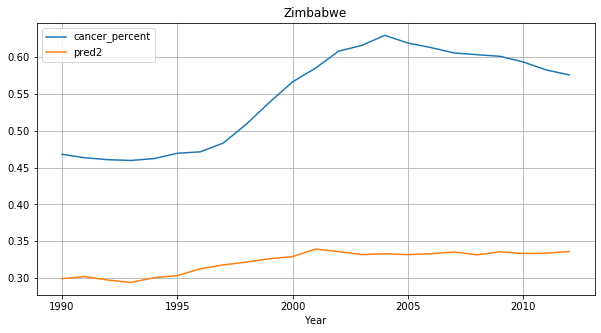

In [56]:
country = 'Zimbabwe'

df_country = df['Entity']== country
df_country = df[df_country]


df_country.plot(x='Year', y=['cancer_percent', 'pred2'], title = country,  figsize=(10,5), grid=True)

In [65]:
# choropleth error
import numpy as np
import folium

world_geo = r'world_countries.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
#threshold_scale = np.linspace(df['error'].min(),
 #                             df['error'].max(),
  #                            6, dtype=float)

threshold_scale = np.linspace(0,
                              df['error'].max(),
                              6, dtype=float)

threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
world_map.choropleth(
    geo_data=world_geo,
    data=df,
    columns=['Code', 'error'],
    key_on='feature.id',
    threshold_scale=threshold_scale,
    fill_color='OrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='error',
    reset=True
)
world_map

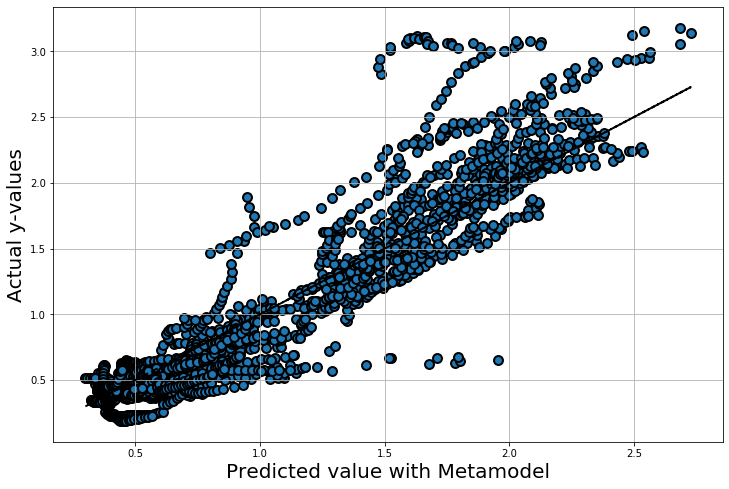

In [66]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y1,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred1,y_pred1, 'k--', lw=2)

# USE OF FOURSQUARE

Now that the job is almost done I have deserved a good meal.
As I don't really know how to use foursquare for this study, I will use it to find a good restaurant for my reward meal.

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

In [ ]:
VERSION = '20180604'
LIMIT = 30

In [ ]:


geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

In [ ]:
search_query = 'Japanese'
radius = 800
print(search_query + ' .... OK!')

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

In [ ]:
results = requests.get(url).json()

In [ ]:
!conda update -c conda-forge -y pandas

In [ ]:
from requests import request
import json
from pandas.io.json import json_normalize

# assign relevant part of JSON to venues
venues = results['response']['venues']

#print(venues)
# tranform venues into a dataframe

dataframe = pd.json_normalize(venues)
dataframe.head()

In [ ]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered



In [ ]:
dataframe_filtered.name

In [ ]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [ ]:
venue_id = dataframe_filtered['id'][0] 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

In [ ]:
result = requests.get(url).json()

In [ ]:
try:
    print(result['response']['venue']['name'], ':',result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

In [ ]:
venue_id = dataframe_filtered['id'][0] # ID of Conca Cucina Italian Restaurant
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['name'], ':',result['response']['venue']['rating'])
except:
    print(result['response']['venue']['name'],' has not been rated yet.')